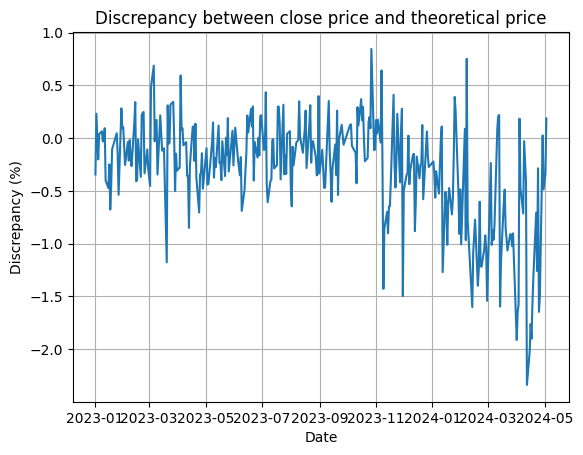

In [91]:
import requests
from code_config import INFOMAX_HEADER
import pandas as pd

session = requests.Session()

session.verify = False
api_url = 'https://infomaxy.einfomax.co.kr/api/future/active'

params = {"underline":"F5","endDate":"20241202","startDate":"20230101"}

r = session.get(api_url, params = params, headers = INFOMAX_HEADER)

success, result = r.json().values()

df = pd.DataFrame(result)

df['discrepancy'] = (df['close_price'] - df['theoretical_price'])/df['close_price'] * 100
import matplotlib.pyplot as plt
from datetime import datetime
df['datetime'] = df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
plt.plot(df['datetime'], df['discrepancy'])
plt.xlabel('Date')
plt.ylabel('Discrepancy (%)')
plt.title('Discrepancy between close price and theoretical price')
plt.grid()
plt.show()



In [112]:
import requests
from code_config import INFOMAX_HEADER
import pandas as pd

session = requests.Session()

session.verify = False
api_url = 'https://infomaxy.einfomax.co.kr/api/future/active'

params = {"underline":"01","endDate":"20241202","startDate":"20230101"}

r = session.get(api_url, params = params, headers = INFOMAX_HEADER)

success, result = r.json().values()

df = pd.DataFrame(result)

print(df[['date', 'close_price']])

         date  close_price
0    20240503       364.50
1    20240502       365.35
2    20240430       367.45
3    20240429       365.65
4    20240426       361.90
..        ...          ...
324  20230106       303.25
325  20230105       298.45
326  20230104       297.00
327  20230103       290.95
328  20230102       291.25

[329 rows x 2 columns]


In [150]:
from infomax_base_data import get_etf_pdf
import QuantLib as ql
from datetime import datetime

code = "122630"
cal = ql.SouthKorea()
cal.addHoliday(ql.Date(1, 5, 2024))
cal.addHoliday(ql.Date(29, 12, 2023))

st_dt = ql.Date(1, 1, 2023)
df_list = []
for i in range(80):
    st_dt = st_dt + ql.Period("1D")
    if cal.isBusinessDay(st_dt):
        dt_str = st_dt.to_date().strftime('%Y%m%d')
        foo = get_etf_pdf(code, dt_str)
        df_list.append(foo)

df_ = pd.concat(df_list)

In [151]:
df = df_
df['port_value'] = df['port_value'] / 1000000
print(df)

         date          isin    code     kr_name  constituents admin_number  \
0    20230102  KR7122630007  122630  KODEX 레버리지           207          905   
1    20230102  KR7122630007  122630  KODEX 레버리지           207          905   
2    20230102  KR7122630007  122630  KODEX 레버리지           207          905   
3    20230102  KR7122630007  122630  KODEX 레버리지           207          905   
4    20230102  KR7122630007  122630  KODEX 레버리지           207          905   
..        ...           ...     ...         ...           ...          ...   
201  20230322  KR7122630007  122630  KODEX 레버리지           205          905   
202  20230322  KR7122630007  122630  KODEX 레버리지           205          905   
203  20230322  KR7122630007  122630  KODEX 레버리지           205          905   
204  20230322  KR7122630007  122630  KODEX 레버리지           205          905   
205  20230322  KR7122630007  122630  KODEX 레버리지           205          905   

      etf_value     port_isin port_code           port_name  po

In [152]:

cu_cash_mask = df['port_code'] == 'H00000'
cash_mask = df['port_code'] == '010010'
other_mask = ~cash_mask & ~cu_cash_mask
cu_cash_df = df[cu_cash_mask]
other_df = df[other_mask]


In [155]:
date_grouped = other_df.groupby('date')['port_value'].sum().reset_index()
date_grouped['change_rate'] = date_grouped['port_value'].pct_change()
cu_cash_df['cash_change_rate'] = cu_cash_df['port_value'].pct_change()

df = date_grouped.merge(cu_cash_df[['date', 'cash_change_rate']], on='date', how='left')
df['diff'] = df['cash_change_rate'] - df['change_rate']
df['diff'].fillna(0.0, inplace=True)
print(df)

        date   port_value  change_rate  cash_change_rate      diff
0   20230102  1284.737210          NaN               NaN  0.000000
1   20230103  1272.712855    -0.009359         -0.010548 -0.001189
2   20230104  1269.969425    -0.002156         -0.001557  0.000598
3   20230105  1322.790305     0.041592          0.042512  0.000920
4   20230106  1343.085225     0.015343          0.011833 -0.003510
5   20230109  1376.932485     0.025201          0.027696  0.002495
6   20230110  1454.242940     0.056147          0.054232 -0.001915
7   20230111  1449.811935    -0.003047         -0.001720  0.001327
8   20230112  1457.593490     0.005367          0.005892  0.000525
9   20230113  1461.396745     0.002609          0.005855  0.003246
10  20230116  1486.574395     0.017228          0.015104 -0.002125
11  20230117  1510.578030     0.016147          0.014999 -0.001148
12  20230118  1487.684655    -0.015155         -0.014271  0.000884
13  20230119  1468.279455    -0.013044         -0.011995  0.00

C:\Users\junbe\AppData\Local\Temp\ipykernel_22184\1446860517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu_cash_df['cash_change_rate'] = cu_cash_df['port_value'].pct_change()
C:\Users\junbe\AppData\Local\Temp\ipykernel_22184\1446860517.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original obj

In [156]:
df['diff'].sum()

0.0021075634556652068

In [130]:
other = df[other_mask]
other[['port_value', 'port_volume']].apply(lambda x: x[0] / 1000000 * x[1], axis=1)

C:\Users\junbe\AppData\Local\Temp\ipykernel_22184\2485284363.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  other[['port_value', 'port_volume']].apply(lambda x: x[0] / 1000000 * x[1], axis=1)


1    2.705608e+11
1    2.735920e+11
1    2.742278e+11
1    2.630668e+11
1    2.606392e+11
         ...     
1    1.846419e+11
1    1.813127e+11
1    1.776140e+11
1    1.759122e+11
1    1.779881e+11
Length: 327, dtype: float64

In [126]:
import xlwings as xw
df = df_.copy()
df['date'] = df['date'].astype(str).apply(lambda x: ql.Date(int(x[6:8]), int(x[4:6]), int(x[0:4])))
df['date'] = df['date'].apply(lambda x: cal.adjust(x - ql.Period('1D'), ql.Preceding))
df['date'] = df['date'].apply(lambda x: x.to_date())

cash = df[df['port_code'] == 'H00000'].sort_values(by = 'date', ascending = True)
fut = df[df['port_code'].str.startswith('101')].sort_values(by = 'date', ascending = True)

wb = xw.Book()
# make sheet
wb.sheets.add('fut')
wb.sheets.add('cash')

wb.sheets['cash'].range('A1').options(pd.DataFrame, index=False).value = cash
wb.sheets['fut'].range('A1').options(pd.DataFrame, index=False).value = fut

In [122]:
type(cash)

pandas.core.frame.DataFrame

In [98]:

fut['change_rate'] = fut['fut_price'].pct_change()
cash['cash_value'] = cash['port_value']
fut = fut.merge(cash[['date', 'cash_value']], on = 'date', how = 'left')

In [99]:
fut['est_cash'] = (fut['cash_value'] * (1+fut['change_rate'].shift(-1))).shift(1)
fut['est_diff'] = (fut['cash_value'] - fut['est_cash'])
diff_sum = fut['est_diff'].fillna(0).sum()
diff_sum / fut['cash_value'].iloc[-1]

-0.5184982749615841

In [101]:
fut['cash_change_rate'] = fut['cash_value'].pct_change()

In [105]:
fut['est_diff'] = fut['cash_change_rate'] + fut['change_rate']

In [110]:
import numpy as np
fut['date_diff'] = None
fut['date_diff'].iloc[1:] = np.diff(fut['date'])

C:\Users\junbe\AppData\Local\Temp\ipykernel_22184\2788071957.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fut['date_diff'].iloc[1:] = np.diff(fut['date'])
C:\Users\junbe\AppData\Local\Temp\ipykernel_22184\2788071957.py:3: SettingWithC

In [111]:
fut

,date,port_name,port_code,port_value,port_volume,fut_price,change_rate,cash_value,est_cash,est_diff,cash_change_rate,date_diff
0,"December 29th, 2022",2023-03 코스피200지수선물,101T30,-518344500,-7.08,292.85,NaN,520154570,NaN,NaN,NaN,None
1,"January 2nd, 2023",2023-03 코스피200지수선물,101T30,-522065625,-7.17,291.25,-0.005464,523060237,5.173127e+08,0.000123,0.005586,4
2,"January 3rd, 2023",2023-03 코스피200지수선물,101T30,-523710000,-7.20,290.95,-0.001030,523667654,5.225215e+08,0.000131,0.001161,1
3,"January 4th, 2023",2023-03 코스피200지수선물,101T30,-511582500,-6.89,297.00,0.020794,512900380,5.345568e+08,0.000233,-0.020561,1
4,"January 5th, 2023",2023-03 코스피200지수선물,101T30,-508857250,-6.82,298.45,0.004882,510528327,5.154044e+08,0.000257,-0.004625,1
...,...,...,...,...,...,...,...,...,...,...,...,...
337,"April 25th, 2024",2024-06 코스피200지수선물,101V60,-430320000,-4.80,358.60,-0.016321,429699795,4.158659e+08,0.000079,0.016401,1
338,"April 26th, 2024",2024-06 코스피200지수선물,101V60,-424327750,-4.69,361.90,0.009202,425808302,4.336541e+08,0.000146,-0.009056,1
339,"April 29th, 2024",2024-06 코스피200지수선물,101V60,-421411625,-4.61,365.65,0.010362,421442786,4.302205e+08,0.000110,-0.010252,3
340,"April 30th, 2024",2024-06 코스피200지수선물,101V60,-421648875,-4.59,367.45,0.004923,419418844,4.235174e+08,0.000120,-0.004802,1
